In [ ]:
import sys , os
sys.path.append('../')

from dnn.bitwise_autoencoder import *
from dnn.bitwise_ss import *
from datasets.two_source_mixture import *
from datasets.sinusoidal_data import *
from datasets.quantized_data import *
from datasets.binary_data import *
from loss_and_metrics.bss_eval import *
import torch
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd
import mir_eval
import matplotlib
import matplotlib.pyplot as plt

# Inverse Blues colormap
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
plt.register_cmap(name='InvBlueA', data=cdict)

# Customize my figure style
plt.rc('figure', figsize=(8,4), dpi=96, facecolor='#FFFFFF00', autolayout=False)
plt.rc('lines', linewidth=1)
plt.rc('axes', axisbelow=True, titlesize=10, titleweight=500, 
   labelsize=9, labelweight=400, linewidth=0.5, facecolor='#FFFFFF00')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes.spines', right=False, top=False)
plt.rc('grid', linestyle='-', linewidth=0.5)

# Get a decent figure font
matplotlib.font_manager._rebuild()
plt.rc('font', family='Avenir Next LT Pro', weight=400, size=9)

# Light colors
plt.rc('axes', edgecolor='#404040')
plt.rc('grid', color='#DDDDDD')
plt.rc('xtick', color='#222222')
plt.rc('ytick', color='#222222')
plt.rc('text', color='#222222')
plt.rc('image', cmap='InvBlueA')
plt.rc('legend', facecolor='#FFFFFF55', framealpha=0.5)

%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [ ]:
def evaluate_binary_sample(model, binary_sample, raw_sample, idx=0):
    sample = raw_sample
    mix = sample['mixture']
    target = sample['target']
    val_mag, val_phase = stft(mix)
    interference = sample['interference']
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = flatten(bmag)
    premask = model(model_in)
    premask = unflatten(premask, bmag.size(0), bmag.size(2))
    mask = make_binary_mask(premask).squeeze(0)
    estimate = istft(val_mag * mask.numpy(), val_phase)
    sources = np.stack([target, interference], axis=0)
    metric = bss_eval_np(estimate, sources)
    return metric

def evaluate_binary(model, binary_test, testset, max_samples=400):
    bss_metrics = BSSMetricsList()
    for i in range(len(binary_val)):
        if i >= max_samples:
            return bss_metrics
        metric = evaluate_binary_sample(model, binary_test[i], testset[i], idx=0)
        bss_metrics.append(metric)
    return bss_metrics
    
def get_audio_output(model, binary_sample, raw_sample):
    mix = raw_sample['mixture']
    target = raw_sample['target']
    val_mag, val_phase = stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = flatten(bmag)
    premask = model(model_in)
    premask = unflatten(premask, bmag.size(0), bmag.size(2))
    mask = make_binary_mask(premask).squeeze(0)
    estimate = istft(val_mag * mask.numpy(), val_phase)
    ipd.display(ipd.Audio(mix, rate=16000))
    ipd.display(ipd.Audio(estimate, rate=16000))
    ipd.display(ipd.Audio(target, rate=16000))

In [ ]:
valset = DatasetFromDirectory('/media/data/binary_audio/val', template='binary_data*.npz')
raw_valset = DatasetFromDirectory('/media/data/binary_audio/val', template='raw_data*.npz')
testset = DatasetFromDirectory('/media/data/binary_audio/test', template='binary_data*.npz')
raw_testset = DatasetFromDirectory('/media/data/binary_audio/val', template='raw_data*.npz')
print('Number of Binary Validation Examples: ', len(valset))
print('Number of Binary Test Examples: ', len(testset))

## Bitwise Neural Network Evaluation

In [11]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net_weighted_bce.model'))
mlp.eval()
met_wbce = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_wbce.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  8.624231863000604
Mean SIR:  20.71205557925583
Mean SAR:  9.164028829385092


In [12]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net_noise.model'))
mlp.eval()
met_noise = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_noise.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  2.480917935638152
Mean SIR:  2.8485541320821084
Mean SAR:  16.086393510550906


In [28]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_weighted_bce.model'))
mlp.eval()
mlp.noisy()
bmet_wbce = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_wbce.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.565723475468421
Mean SIR:  15.849066301727323
Mean SAR:  8.77114636989063


In [18]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net_mse.model'))
mlp.eval()
met_mse = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_mse.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  4.251969433355379
Mean SIR:  5.144988077897499
Mean SAR:  13.93948061711041


In [36]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_mse.model'))
mlp.eval()
mlp.noisy()
bmet_mse = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_mse.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  3.760537703075987
Mean SIR:  4.32813749837647
Mean SAR:  15.726148957734297


In [37]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net_wmse.model'))
mlp.eval()
met_wmse = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_wmse.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  4.211570878345541
Mean SIR:  4.904071614415937
Mean SAR:  14.525633063352142


In [25]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_wmse.model'))
mlp.eval()
mlp.noisy()
bmet_wmse = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_wmse.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  4.664927389715761
Mean SIR:  5.768207904813437
Mean SAR:  12.780187580375841


In [7]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/net.model'))
mlp.eval()
met = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.861241161235858
Mean SIR:  18.926905274322365
Mean SAR:  8.579021307836905


In [27]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp0.model'))
mlp.eval()
mlp.noisy()
bmet_sp0 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp0.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.105669722027781
Mean SIR:  16.710140954306976
Mean SAR:  8.08970022621809


In [39]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp33.model'))
mlp.eval()
mlp.noisy()
bmet_sp33 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp33.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.353862449261794
Mean SIR:  16.883198590087996
Mean SAR:  8.370371993069543


In [38]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp40.model'))
mlp.eval()
mlp.noisy()
bmet_sp40 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp40.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.226039097119659
Mean SIR:  16.83054274410047
Mean SAR:  8.2343903183572


In [32]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bnet_sp50.model'))
mlp.eval()
mlp.noisy()
bmet_sp50 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_sp50.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.273326017385968
Mean SIR:  16.69879864122628
Mean SAR:  8.31037192531624


In [42]:
# Evaluate real filter gate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/net_ug.model'))
mlp.eval()
met_ug = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_ug.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  7.881682055423843
Mean SIR:  19.257724970886844
Mean SAR:  8.559218150539966


In [48]:
# Evaluate binary filter gate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/bnet_ug.model'))
mlp.eval()
mlp.noisy()
bmet_ug = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = bmet_ug.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

total_pass = torch.sum((mlp.filter_list[0].gate > 0).float()) + \
      torch.sum((mlp.filter_list[1].gate > 0).float()) + \
      torch.sum((mlp.filter_list[2].gate > 0).float())
total_units = mlp.filter_list[0].gate.view(-1).size(0) + \
     mlp.filter_list[1].gate.view(-1).size(0) + \
     mlp.filter_list[2].gate.view(-1).size(0)
total_pass / total_units

Mean SDR:  7.418773649988774
Mean SIR:  17.702535596861193
Mean SAR:  8.259114110513165


tensor(0.5163)

In [63]:
# Evaluate
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/net_ug_noise.model'))
mlp.eval()
met_nt1 = evaluate_binary(mlp, binary_test, testset)
sdr, sir, sar = met_nt1.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_test[0], testset[0])

Mean SDR:  0.5032141293670163
Mean SIR:  3.15580203377805
Mean SAR:  6.194645196722038


In [29]:
sdrs = np.stack([bmet_mse.sdrs, bmet_wmse.sdrs, bmet_sp0.sdrs, bmet_wbce.sdrs], axis=1)
sirs = np.stack([bmet_mse.sirs, bmet_wmse.sirs, bmet_sp0.sirs, bmet_wbce.sirs], axis=1)
sars = np.stack([bmet_mse.sars, bmet_wmse.sars, bmet_sp0.sars, bmet_wbce.sars], axis=1)
labels = ['mse', 'weighted mse', 'bce', 'weighted bce']

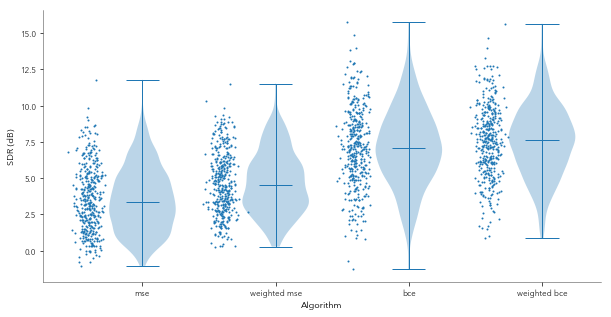

In [38]:
plt.figure(figsize=(10, 5))
plt.violinplot(sdrs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sdrs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SDR (dB)')
plt.savefig('sdrs.png')

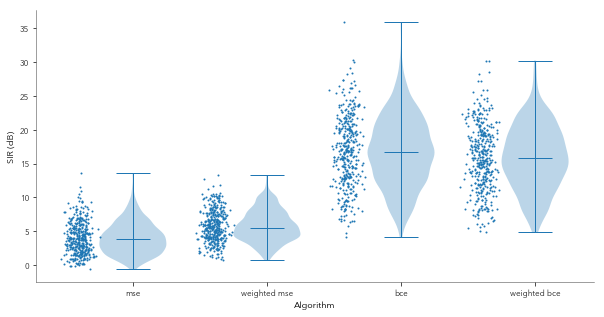

In [39]:
plt.figure(figsize=(10, 5))
plt.violinplot(sirs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sirs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')
plt.savefig('sirs.png')

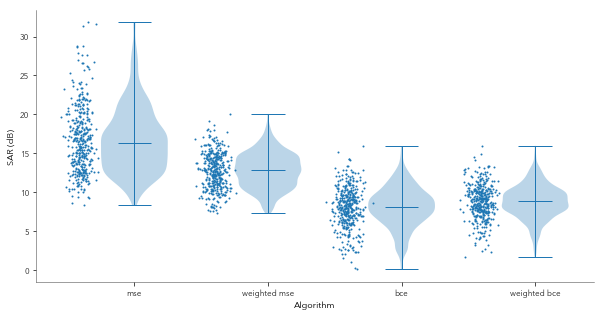

In [40]:
plt.figure(figsize=(10, 5))
plt.violinplot(sars, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sars[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')
plt.savefig('sars.png')